# Imports and definitions

In [1]:
from utils import *
from paths_and_parameters import *
path_phases_check = path_figures + 'phases_check/'

first_n_peaks = 5

### Rotating the image clockwise: number of steps of 90 degrees ###
steps_rotation_photo = 0
steps_rotation_xrd = 0
steps_rotation_xrf = 0

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in [path_figures, path_results, path_database_exp]:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in [path_figures, path_results, path_database_exp]:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read and show photo of scanned section

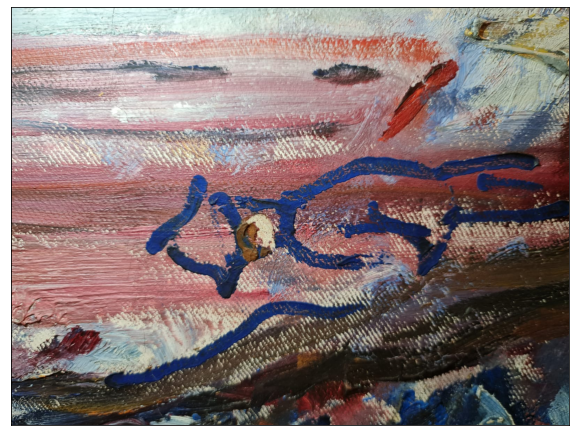

In [4]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    img_photo = Image.open(filename)
    fig, ax = subplots(figsize = (10, 10))
    ax.imshow(img_photo.transpose(1).rotate(90 * steps_rotation_photo, expand = True))
    ax.set_yticks([])
    ax.set_xticks([])
    show()

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [5]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 369


# Burnt pixels

### Show them
Choose a quantile on the value of maximum channel. All pixels above that quantile will be considered burnt pixel.

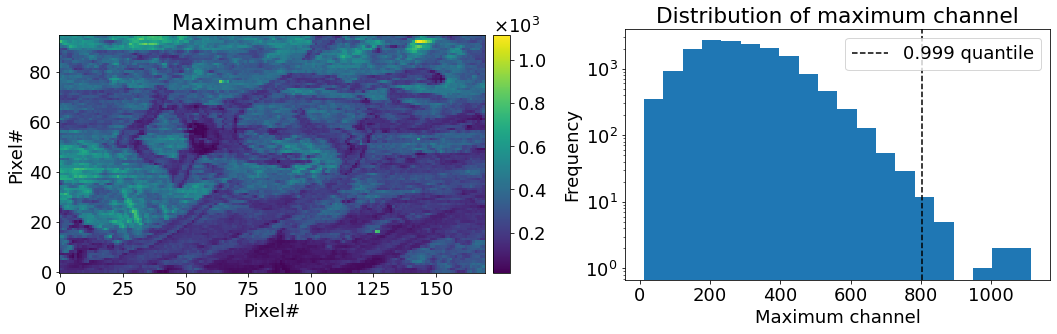

17 pixels out of 16150 are selected as burnt.


In [6]:
rcParams['font.size'] = 18

qtl = 0.999
#qtl = 1

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

fig, axs = subplots(1, 2, figsize = (15, 8 * y_x_ratio))
fig.tight_layout(w_pad = 5)

ax = axs[0]
data_to_process = data.data - data.background
im = ax.imshow(data_max, interpolation = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Maximum channel')

ax = axs[1]
ax.hist(data_max.flatten(), bins = 'doane') # 'sqrt'
ax.axvline(quantile(data_max, qtl), c = 'black', ls = '--', label = f'{qtl} quantile')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Maximum channel')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of maximum channel')

show()
print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} are selected as burnt.')

### Correct them
Substitute burnt pixel with the average of the non burnt ones.

In [7]:
data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Aggregated information about XRD data

We process raw XRD data by subtracting the background (obtained by SNIP).
On this data we calculate aggregated information.

### Integral, average and maximum

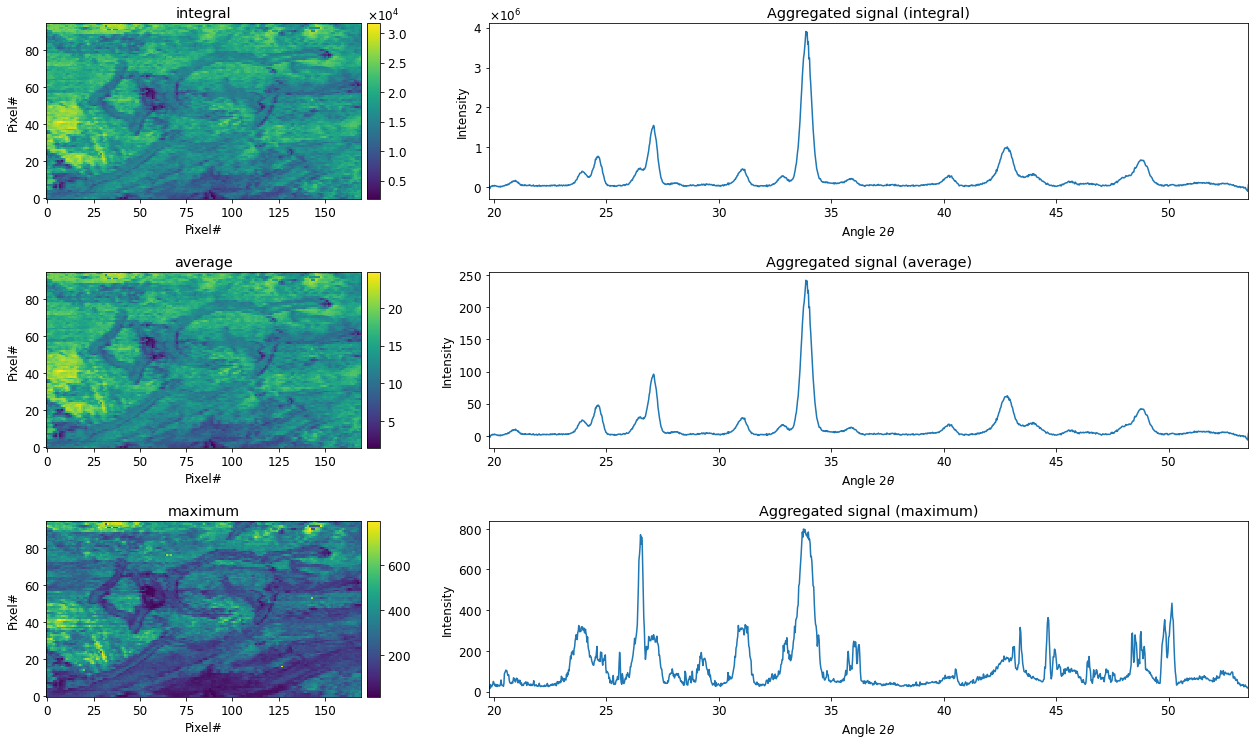

In [8]:
rcParams['font.size'] = 12

fig, axs = subplots(3, 2, figsize = (18, 3 * 6 * y_x_ratio), gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 4, w_pad = 5)

theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
data_to_process = data.data - data.background

for i in range(len(list_aggregations)):
    
    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated, interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    
    xrdpattern_aggregated = list_functions[i](data_to_process, axis = (0, 1))
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

### Rescaling and signal / background ratio

- 'Rescaling' shows, for each pixel, the maximum value of the experimental diffraction pattern after we subtract the background.
This value is used to obtain the rescaled signal in the interval [0, 1].
That's why we indicate this value as 'rescaling'.

- 'Signal/Noise' indicates the integral of the experimental diffraction pattern divided by the integral of the background.

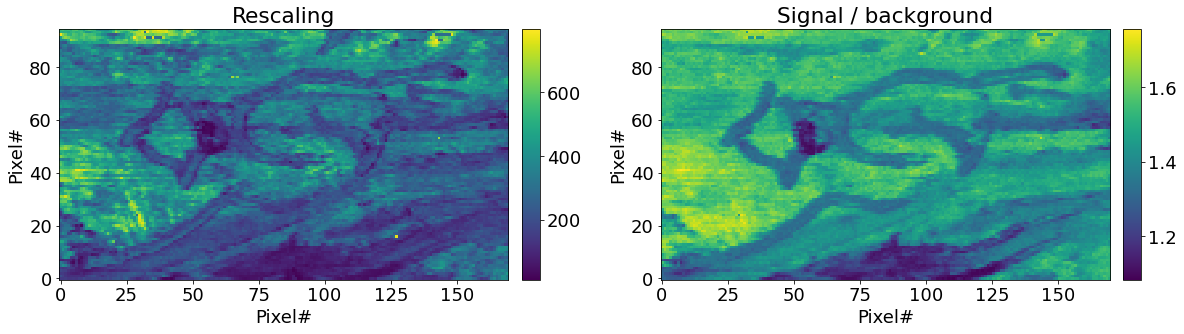

In [9]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (16, 8 * y_x_ratio))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

ax = axs[1]
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal / background')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

show()

# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [10]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf_images)
data_xrf.labels = flip(data_xrf.labels, axis = xrf_axes_flip)
data_xrf.rotate(steps_rotation_xrf)
y_x_ratio = data_xrf.labels.shape[0] / data_xrf.labels.shape[1]
print(f'Found {data_xrf.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf.metadata['labels']]))
print(f'Size of XRF scan: {data_xrf.labels.shape[1], data_xrf.labels.shape[0]}')

Found 24 images: Al_K, Ar_K, As_K, Ba_L, Ca_K, Cd_L, Cl_K, Co_K, Cr_K, Cu_Ka, Cu_Kb, Fe_K, Hg_L, K_K, Mn_K, P_K, Pb_L, Pb_M, S_K, Se_K, Si_K, Sn_L, Ti_K, Zn_K
Size of XRF scan: (170, 95)


### Correct burnt pixels and wrong scale in each XRF map; also calculate normalized XRF maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [11]:
qtl = 0.995
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1), keepdims = True)
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

### Correct specific pixel ###
#pixels_to_correct = []
pixels_to_correct = [(0, 0)]
for x, y in pixels_to_correct:
    for i in range(data_xrf.labels.shape[2]):
        data_xrf.labels[y, x, i] = nanmin(data_xrf.labels[..., i])

maps_xrf_norm = data_xrf.labels / data_xrf.labels.max(axis = (0, 1), keepdims = True)

81 pixels out of 16150 were corrected on average in each XRF map.


# Obtain list of phases

### Search phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [12]:
elements_chosen = ['Fe']
elements_excluded = []
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Akaganeite,Cl0.675 Fe4 O8,2
1,Erythrite,As4 Co4.02 Fe1.48 H32 Ni0.50 O32,1
2,Fe2 O3,Fe2 O3,10
3,Fe2MnO4,Fe2 Mn O4,1
4,Goethite,Fe H O2,22
5,Hematite,Fe2 O3,13
6,Jacobsite,Al0.049 Fe1.911 Mg0.736 Mn0.284 O4 Zn0.017,4
7,Jarosite,Fe2.88 H5.83 K0.81 O13.64 S2,16
8,Lepidocrocite,Fe H O2,2
9,Magnetite,Fe3 O4,1


### Select the area given by XRF threshold
- `threshold_XRF_intensity`: The routine selects pixels where the first of `elements_chosen` has an XRF intensity above this threshold value.

Element chosen for the map of XRF intensity: Fe_K
Threshold: 0.4
Selected pixels: 140


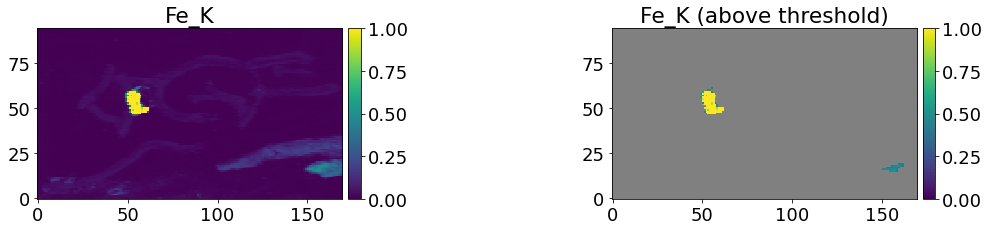

In [13]:
threshold_XRF_intensity = 0.4

idx_element = find_element(elements_chosen[0], data_xrf.metadata['labels'])
print('Element chosen for the map of XRF intensity: ' + data_xrf.metadata['labels'][idx_element])
print(f'Threshold: {threshold_XRF_intensity}')

indices_XRF_sel = zeros(data_xrf.labels.shape[:2], bool)
for x in range(data_xrf.labels.shape[1]):
    for y in range(data_xrf.labels.shape[0]):
        if maps_xrf_norm[y, x, idx_element] >= threshold_XRF_intensity:
            indices_XRF_sel[y, x] = True
print(f'Selected pixels: {indices_XRF_sel.sum()}')

map_for_search = maps_xrf_norm[..., idx_element].copy()
map_for_search[~indices_XRF_sel] = None

fig, axs = subplots(1, 2, figsize = (8 * 2, 6 * y_x_ratio))
fig.tight_layout(w_pad = 2)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

ax = axs[0]
im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none')
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_title(data_xrf.metadata['labels'][idx_element])

ax = axs[1]
im = ax.imshow(map_for_search, interpolation = 'none', vmin = 0, vmax = 1, cmap = cmap_viridis)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_title(data_xrf.metadata['labels'][idx_element] + ' (above threshold)')

show()

### In selected area, find the pixel of maximum XRF intensity of the first `elements_chosen`

In [14]:
position = nanargmax(map_for_search.flatten())
y_xrf, x_xrf = unravel_index(position, map_for_search.shape)
print(f'{(x_xrf, y_xrf)}')

(53, 47)


### Check phases vs smoothed XRD pattern in the given pixel

#### Parameters of the smoothing of XRD pattern
- `offset_background`: value added to the background, before subtracting it from the raw signal
- `std_smooth`: degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

#### Phases
- `phases_calibration`: the cell will calibrate the mix of these phases on the experimental XRD pattern
- `phase_compare`: the diffraction lines of this phase will be shown for comparison

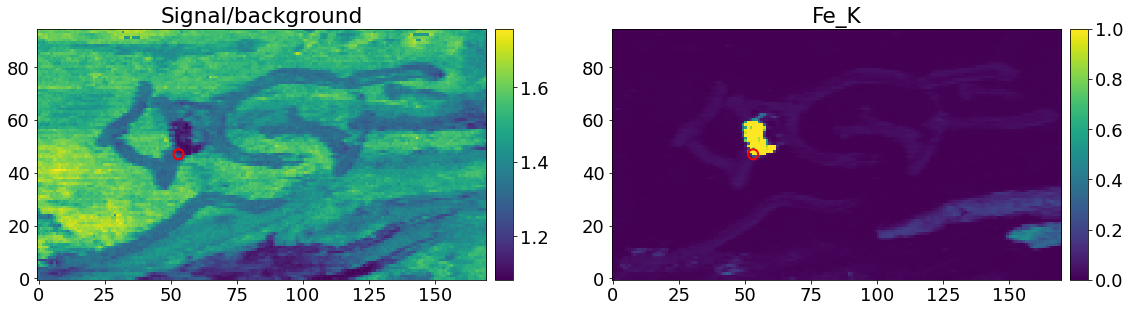

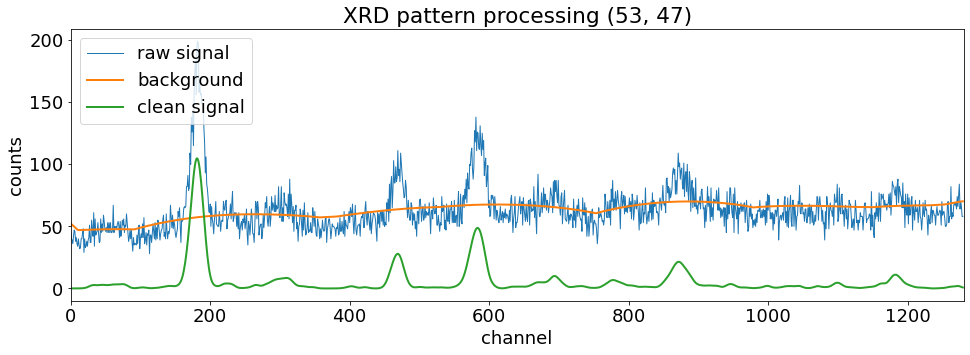

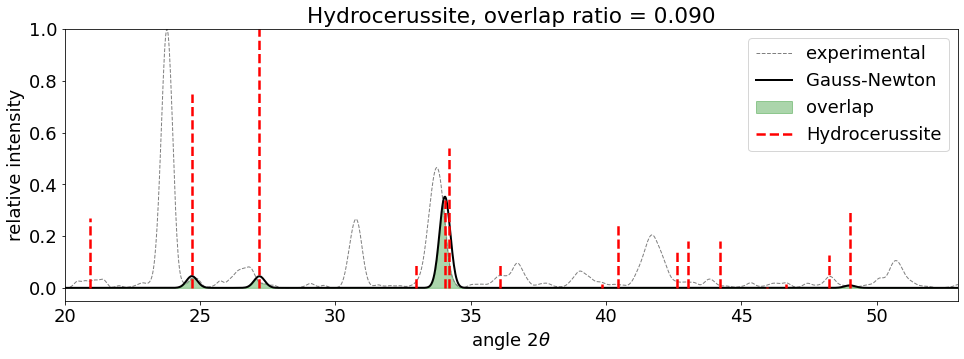

In [15]:
rcParams['font.size'] = 18

offset_background = 10 # default: 0
std_smooth = 5             # set to 0 for no smooth

phases_calibration = database['Hydrocerussite'][0]
#phases_calibration = PhaseList([hematite])

#phase_compare = lazurite
#phase_compare = PhaseList([lazurite])
phase_compare = None

###

x, y = x_xrf, y_xrf

fig, axs = subplots(1, 2, figsize = (8 * 2, 8 * y_x_ratio))
fig.tight_layout(w_pad = 2)

ax = axs[0]
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_title('Signal/background')

ax = axs[1]
im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none')
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_title(data_xrf.metadata['labels'][idx_element])

show()

signal_raw = data.data[y, x]
background = data.background[y, x] + offset_background
signal_no_bg = maximum(signal_raw - background, 0)
signal_smoothed = convolve(signal_no_bg, n = ceil(3 * std_smooth + 1), std = std_smooth)

fig, ax = subplots(figsize = (16, 5))
ax.plot(signal_raw, lw = 1, label = 'raw signal')
ax.plot(background, lw = 2, label = 'background')
ax.plot(signal_smoothed, lw = 2, label = 'clean signal')
ax.legend(frameon = True, loc = 2)
ax.set_xlim(0, len(signal_raw))
ax.set_xlabel('channel')
ax.set_ylabel('counts')
ax.set_title(f'XRD pattern processing {(x, y)}')
show()

spectrum = FastSpectraXRD().from_components(
    opt = data.opt.copy(),
    counts = signal_smoothed,
    rescaling = nanmax(signal_smoothed),
    intensity = signal_smoothed / nanmax(signal_smoothed)
)
gn = GaussNewton(phases_calibration, spectrum, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 10)

### Optimizes calibration and heights of the peaks ###
#gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
ax.fill_between(gn.theta, gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(lw = 2.5, alpha = 1)
if phase_compare is not None:
    phase_compare.plot(color = 'g')
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'{gn.label}, overlap ratio = {gn.overlap3_area_ratio():.3f}')
ax.legend(frameon = True, loc = 'upper right')
show()

### Fit selected phases on smoothed XRD pattern in selected area

#### Parameters of the smoothing of XRD pattern
- `offset_background`: value added to the background, before subtracting it from the raw signal
- `std_smooth`: degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

In [16]:
offset_background = 10 # default: 0
std_smooth = 5         # set to 0 for no smooth

data.smooth_channels(offset_background, std_smooth)

list_overlap = []
list_overlap_avg = []
list_overlap_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]
    print(f'Calculations for {phase_name} ({len(phase_set)})... ', end = '')
    gm = GammaMap_Partial().from_data(data, [p for p in phase_set], indices_XRF_sel, sigma = sigma, min_theta = min_theta,
                                      max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
    gm = gm.fit_cycle(gamma = True, steps = 10, verbose = False)
    overlap = gm.overlap3_area_ratio(verbose = False)
    list_overlap.append(overlap)
    list_overlap_avg.append(nanmean(overlap, axis = 0))
    list_overlap_max.append(nanmax(overlap, axis = 0))
    list_x_y_sample = []
    for j in range(len(phase_set)):
        list_x_y_sample.append(gm.get_x_y(nanargmax(overlap[:, j])))
    list_x_y.append(array(list_x_y_sample))
    
    print('Done.')

df_phases['Best avg overlap'] = [nanmax(list_overlap_avg[i]) for i in range(df_phases.shape[0])]
df_phases['Best max overlap'] = [nanmax(list_overlap_max[i]) for i in range(df_phases.shape[0])]
df_phases.style.format({'Best avg overlap': '{:.3f}', 'Best max overlap': '{:.3f}'})

Calculations for Akaganeite (2)... Done.
Calculations for Erythrite (1)... Done.
Calculations for Fe2 O3 (10)... Done.
Calculations for Fe2MnO4 (1)... Done.
Calculations for Goethite (22)... Done.
Calculations for Hematite (13)... Done.
Calculations for Jacobsite (4)... Done.
Calculations for Jarosite (16)... Done.
Calculations for Lepidocrocite (2)... Done.
Calculations for Magnetite (1)... Done.
Calculations for Manganese diiron(III) oxide (1)... Done.
Calculations for Mn Fe2 O4 (2)... Done.
Calculations for Pyrite (9)... Done.
Calculations for Siderite (2)... Done.
Calculations for Wuestite (11)... Done.


,Name in database,Chemical formula,N. of samples,Best avg overlap,Best max overlap
0,Akaganeite,Cl0.675 Fe4 O8,2,0.079,0.268
1,Erythrite,As4 Co4.02 Fe1.48 H32 Ni0.50 O32,1,0.047,0.425
2,Fe2 O3,Fe2 O3,10,0.173,0.499
3,Fe2MnO4,Fe2 Mn O4,1,0.042,0.112
4,Goethite,Fe H O2,22,0.143,0.477
5,Hematite,Fe2 O3,13,0.147,0.508
6,Jacobsite,Al0.049 Fe1.911 Mg0.736 Mn0.284 O4 Zn0.017,4,0.039,0.130
7,Jarosite,Fe2.88 H5.83 K0.81 O13.64 S2,16,0.125,0.270
8,Lepidocrocite,Fe H O2,2,0.079,0.202
9,Magnetite,Fe3 O4,1,0.042,0.145


### Select phase samples as primary or secondary phases

##### How thresholds are used
- `thresholds_overlap_avg`. If avg overlap of a phase is above the second threshold, the phase can be selected as primary. Otherwise, if avg overlap is above the first threshold, the phase can be selected as secondary.
- `factor_quantile` ($f$). Let $q_1$ and $q_3$ be the first and third quantiles of the population of overlap values of a given phase sample in the selected pixels. If the maximum overlap is above $q_3 + f (q_3 - q_1)$, the phase sample is discarded for having outlier overlap values.

##### Note
If a phase is selected as primary, it is prevented from being selected as secondary, even with a different sample.

In [17]:
thresholds_overlap_avg = [0.1, 0.3]
factor_quantile = 2 # the higher, the more permissive the filter is with respect to outliers


def outlier_threshold(population, factor = 1.5):
    q1 = quantile(population, 0.25)
    q3 = quantile(population, 0.75)
    return q3 + factor * (q3 - q1)


list_sel_category = []
list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_overlap_avg = []
list_sel_overlap_max = []
list_sel_x_y_overlap_max = []

for i in range(df_phases.shape[0]):
    arr_outlier_threshold = array([outlier_threshold(list_overlap[i][:, j], factor_quantile) for j in range(df_phases.loc[i, 'N. of samples'])])
    idx = (list_overlap_avg[i] >= thresholds_overlap_avg[1]) & (list_overlap_max[i] <= arr_outlier_threshold)
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_overlap_avg_filtered = list_overlap_avg[i][idx]
        arr_overlap_max_filtered = list_overlap_max[i][idx]
        arr_x_y_filtered = list_x_y[i][idx]
        j = nanargmax(arr_overlap_avg_filtered)
        
        list_sel_category.append('Primary')
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_overlap_avg.append(arr_overlap_avg_filtered[j])
        list_sel_overlap_max.append(arr_overlap_max_filtered[j])
        list_sel_x_y_overlap_max.append(tuple(arr_x_y_filtered[j]))
    else:
        idx = (list_overlap_avg[i] >= thresholds_overlap_avg[0]) & (list_overlap_max[i] <= arr_outlier_threshold)
        if any(idx):
            arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
            arr_overlap_avg_filtered = list_overlap_avg[i][idx]
            arr_overlap_max_filtered = list_overlap_max[i][idx]
            arr_x_y_filtered = list_x_y[i][idx]
            j = nanargmax(arr_overlap_avg_filtered)

            list_sel_category.append('Secondary')
            list_sel_name.append(df_phases.loc[i, 'Name in database'])
            list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
            list_sel_sample.append(arr_sample_filtered[j])
            list_sel_overlap_avg.append(arr_overlap_avg_filtered[j])
            list_sel_overlap_max.append(arr_overlap_max_filtered[j])
            list_sel_x_y_overlap_max.append(tuple(arr_x_y_filtered[j]))

df_phases_sel = DataFrame({
    'Category': list_sel_category,
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Overlap avg': list_sel_overlap_avg,
    'Overlap max': list_sel_overlap_max,
    '(x, y) overlap max': list_sel_x_y_overlap_max
})
df_phases_sel = df_phases_sel.sort_values(by = ['Category', 'Phase']).reset_index(drop = True)
df_phases_sel.style.format({'Overlap avg': '{:.3f}', 'Overlap max': '{:.3f}'})

,Category,Phase,Formula,Sample,Overlap avg,Overlap max,"(x, y) overlap max"
0,Secondary,Fe2 O3,Fe2 O3,5,0.110,0.328,"(51, 55)"
1,Secondary,Goethite,Fe H O2,20,0.100,0.338,"(51, 55)"
2,Secondary,Hematite,Fe2 O3,10,0.110,0.330,"(51, 55)"
3,Secondary,Jarosite,Fe2.88 H5.83 K0.81 O13.64 S2,15,0.125,0.270,"(56, 53)"


### Add selected phases to their appropriate files

This cell writes the list of names of selected phases into the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`. If the files do not exist, the cell creates them.

In [18]:
for category in ['Primary', 'Secondary']:
    filename = f'{subfolder_output}phases_selection_{category.lower()}.dat'
    df_phases_sel.loc[df_phases_sel['Category'] == category, ['Phase', 'Formula', 'Sample', 'Overlap avg', 'Overlap max']]\
    .to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f')

### Delete the files with list of selected phases
Delete the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`.

In [19]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for file_name in ['phases_selection_primary.dat', 'phases_selection_secondary.dat']:
        if exists(subfolder_output + file_name):
            remove(subfolder_output + file_name)

# Check list of phases

### Check the fit of every phase in the point of maximum overlap and save figures

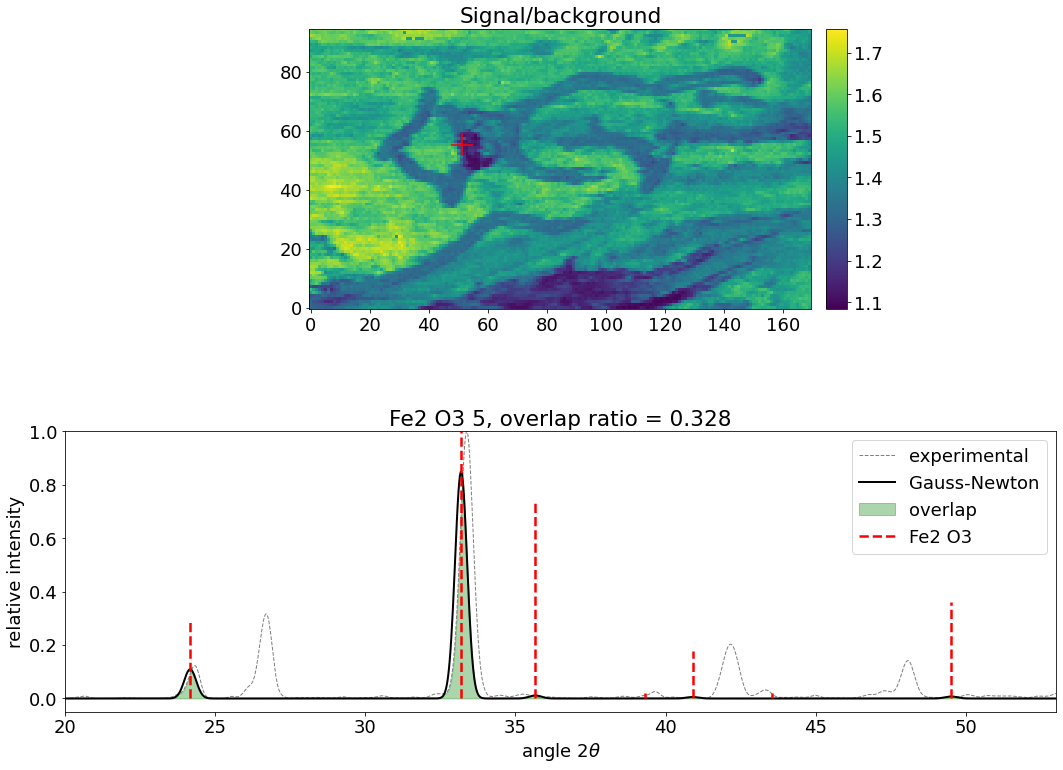

<Figure size 432x288 with 0 Axes>

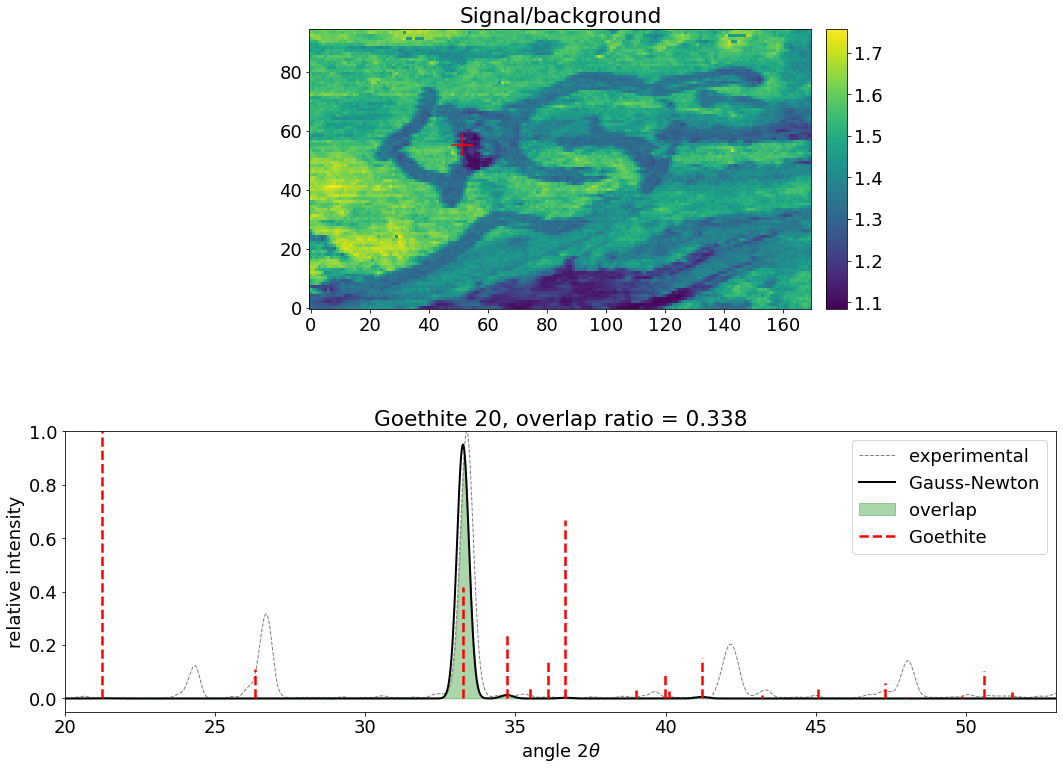

<Figure size 432x288 with 0 Axes>

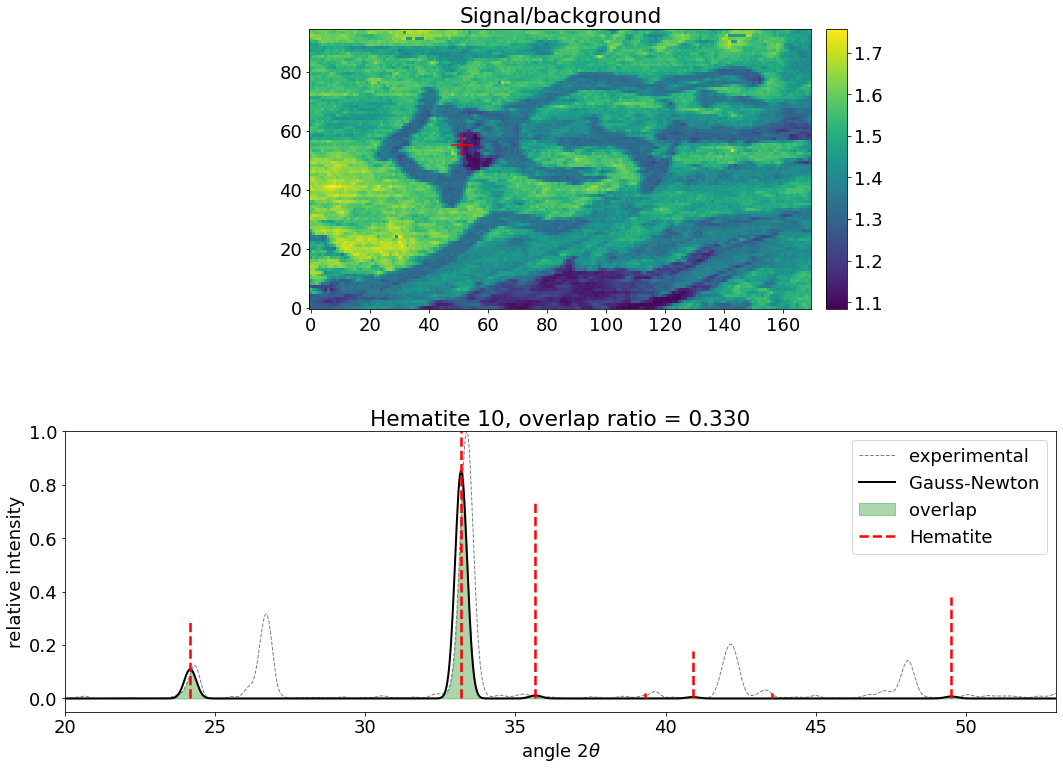

<Figure size 432x288 with 0 Axes>

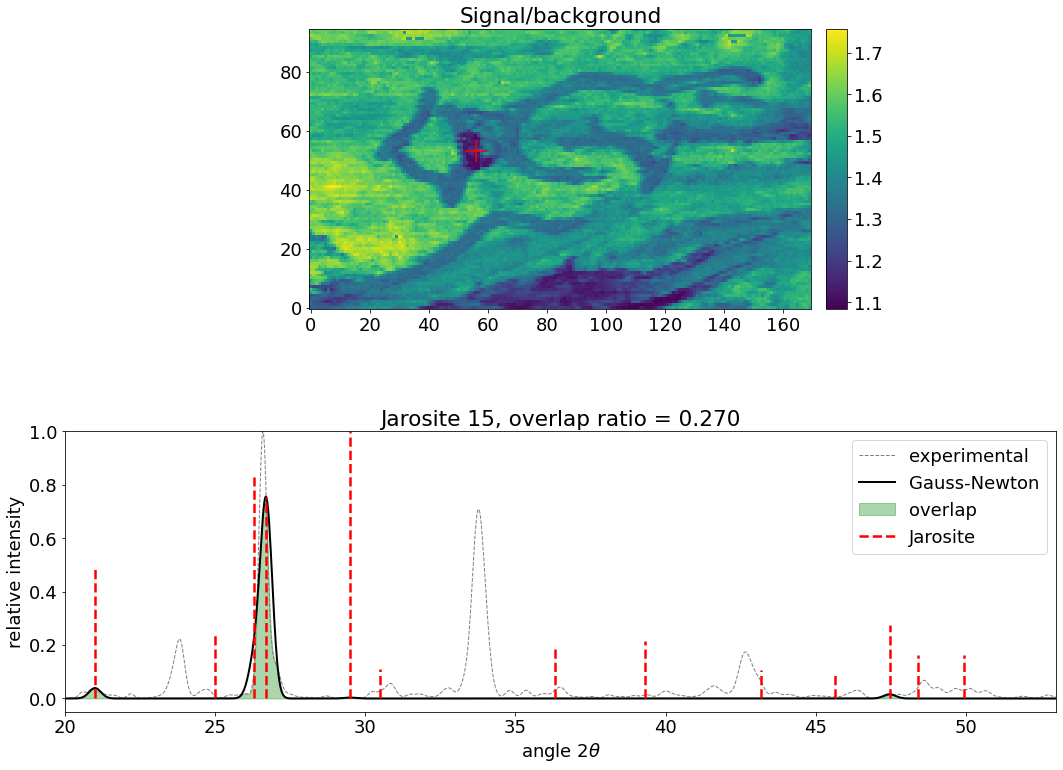

<Figure size 432x288 with 0 Axes>

In [20]:
rcParams['font.size'] = 18

if not isdir(path_phases_check):
    makedirs(path_phases_check)

for i in range(df_phases_sel.shape[0]):
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    x, y = df_phases_sel.loc[i, '(x, y) overlap max']
    phase_check = database[phase_name][phase_sample]
    gn = GaussNewton(phase_check, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

    ### Leaves initial calibration and only optimizes the heights of the peaks ###
    gn.fit_cycle(gamma = True, steps = 10)

    ### Optimizes calibration and heights of the peaks ###
    #gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

    fig, axs = subplots(2, 1, figsize = (15, 8 * y_x_ratio + 6))
    fig.tight_layout(h_pad = 5)

    ax = axs[0]
    im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
    ax.scatter(x, y, s = 500, c = 'red', marker = '+')
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    ax.set_title('Signal/background')

    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    gn.phase.plot(lw = 2.5, alpha = 1)
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'{phase_name} {phase_sample}, overlap ratio = {gn.overlap3_area_ratio():.3f}')
    ax.legend(frameon = True, loc = 'upper right')

    show()
    for c in ['/', '\\']:
        phase_name = phase_name.replace(c, '_')
    savefig(f'{path_phases_check}{phase_name} check_fit.png', bbox_inches = 'tight', dpi = 300)
    close(fig)

### Remove these last figures

In [39]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_phases_check):
        rmtree(path_phases_check)